In [2]:
from cgi import test
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import copy
from sklearn.model_selection import train_test_split
from scipy.stats import halfnorm, expon, uniform, chi, norm
import keras
from keras import callbacks
from keras.layers import Dense, Input, Conv2D, MaxPool2D, LSTM, add
from keras.layers import Activation, Dropout, Flatten, Embedding
from keras.models import Model, Sequential
from keras import backend as K
import tensorflow as tf
import tensorflow_probability as tfp
import scipy.stats
import math
import seaborn as sns
from IPython.display import display

### Exponential distribution generators

In [3]:
def generate_exponential(amount): #Generates a popular playlist
    data = {}
    for i in range(amount):
        data[i] = expon.pdf(i, scale=(amount/7)) 
    return data  

In [4]:
def generate_exponential_inv(amount): #Generates a "niche" (unpopuar) playlist 
    data = {}
    for i in range(amount):
        data[amount - 1 - i] = expon.pdf(i, scale=(amount/7)) 
    return data

### Uniform distribution generator

In [5]:
def generate_uniform(amount): #Generates an uniform distribution among the items
    data = {}
    for i in range(amount):
        data[i] = uniform.pdf(i, scale=amount) 
    return data

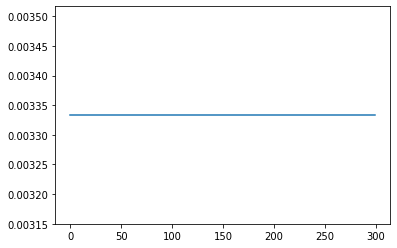

In [6]:
da = generate_uniform(300)
lists = sorted(da.items())
x, y = zip(*lists)
plt.plot(x, y)
plt.show() 

### Aux functions

get_cumulative_prob() GETS THE CUMULATIVE PROBABIITIES OF ITEMS (for later selection)

In [7]:
def get_cumulative_prob(y): 

    cum_prob = {}
    cum_prob[0] = y[0]

    for i in range(1, 300):
        cum_prob[i] = cum_prob[i-1] + y[i]
    return cum_prob

get_playlist() generates a playlist based on the cumulative probabilities its given (for popualar, normal, and rare)

In [8]:
def get_playlists(cum_prob): #CREATES A RANDOM PLAYLLIST

    playlist = [] #empty toy playlist

    #create random playlist (like this bc they dont add to 1)
    while len(playlist) < 20:

        prob = np.random.random()
        #print(prob)
        finished = False
        i = 0
        while i < 300 and finished == False:
            if prob < cum_prob[i] and i not in playlist:
                playlist.append(i)
                finished = True
            i += 1

    playlist.sort()
    return playlist

In [9]:
def get_songs_ordered(songs): #RETURNS A LIST OF SONGS ORDERED BY POPULARITY (AMONG ALL THE PLAYLISTS)
    ordered_songs = []
    songs_copy = copy.deepcopy(songs)

    while songs_copy: 
        max_value = max(songs_copy, key=songs_copy.get)
        ordered_songs.append(max_value)
        songs_copy.pop(max_value)
    #print("Highest used song: ", max_value, " with ", songs_copy[max_value], " instances")
    return ordered_songs

In [10]:
def create_dataframe(list): 
    elems = []
    pred = []
    size = len(list)
    for i in range(size - 1):
        elems.append(list[i])
        pred.append(list[i + 1])
    d = {'Song':elems, 'Next':pred}
    df = pd.DataFrame(d)
    return df

In [11]:
def get_prob_dataframe(probs):
    songs = []
    next = []
    for i in range(len(probs)):
        songs.append(i)
        next.append(probs[i])
    for i in range(len(next[299])):
        next[299][i] = 0
    next[299][298] = 1
    dataframe_next = pd.DataFrame(next)
    d = {'Song': songs}
    df = pd.DataFrame(d)
    result = pd.concat([df, dataframe_next], axis=1, join='inner')
    return result

In case we stop using probabilities use this function not create_dataframe()

In [12]:
def create_training_data(pairs):
    songs = []
    next = []
    for i in range(len(pairs)):
        #max_num = 0
        songs.append(i)
        #max_num = max(pairs[i])
        pred_song = np.argmax(pairs[i])
        next.append(pred_song)
    d = {"Song":songs, "Next":next}
    df = pd.DataFrame(d)
    return df

In [13]:
def split_dataset(dataframe):
    X = dataframe['Song']
    y = dataframe['Next']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    train = {'Song':X_train, 'Next': y_train}
    test = {'Song':X_test, 'Next': y_test}
    return train, test

In [14]:
def split_dataset2(dataframe):
    X = dataframe['Song']
    y = dataframe['Next']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    return X_train, X_test, y_train, y_test

In [15]:
def split_dataset_prob(dataframe):
    X = dataframe['Song']
    dataframe = dataframe.drop('Song', axis=1)
    y = dataframe

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    X_train = X
    y_train = y
    return X_train, X_test, y_train, y_test

In [16]:
def norm_data(data, mean, std):
    songs_norm = (data['Song'] - mean) / std
    data['Song'] = songs_norm
    return data

In case we need tensorflow Datasets

In [17]:
def get_tf_dataset(train, test):
    train_X = tf.data.Dataset.from_tensor_slices(train['Song'])
    train_Y = tf.data.Dataset.from_tensor_slices(train['Next'])

    train_dataset = tf.data.Dataset.zip((train_X, train_Y))
    train_dataset = train_dataset.shuffle(1000).batch(64)
    train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

    test_X = tf.data.Dataset.from_tensor_slices(test['Song'])
    test_Y = tf.data.Dataset.from_tensor_slices(test['Next'])

    test_dataset = tf.data.Dataset.zip((test_X, test_Y))
    test_dataset = test_dataset.shuffle(1000).batch(64)
    test_dataset = test_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

    return train_dataset, test_dataset

create_pairs() creates pairs of numbers, indicating the number of times one appears after the other in the playlists

In [18]:
def create_pairs(playlists): #playlists should be a list of lists, ordered
    pairs = np.zeros((300,300))
    for playlist in playlists:
        for i in range(len(playlist)-1):
            pairs[playlist[i]][playlist[i+1]] += 1
    return pairs

In [19]:
def order_playists(playlists):
    for playlist in playlists:
        playlist.sort()
    return playlists

In [20]:
def get_probabilities(pairs): #Gets the probabilities associated to each pair of numbers, which song is more likely
    for num in range(len(pairs)): #to go after the other
        total = sum(pairs[num])
        pairs[num] /= total
    return pairs

In [21]:
def get_nll(true_song, probs): #true_song has to be in [0,0,0...1,0] format, being the 1 in the correct song index
    nll = 0                     #probs is the output of the nn
    for i in range(len(true_song)):
        nll += true_song[i] * probs[i]
    nll = -np.log(nll)
    return nll

In [22]:
def get_nll_list(expected, idx, predictions): #Returns a list of uncertainties for each prediction
    nll_list = []
    j = 0
    for i in idx:
        true_song = get_true_song(expected[i])
        nll_list.append(get_nll(true_song, predictions[j]))
        j += 1
    return nll_list

In [23]:
def get_true_song(next_songs): #returns expected song, represented as one_hot
    true_song = []
    item = np.argmax(next_songs)
    for i in range(len(next_songs)):
        if i == item:
            true_song.append(1)
            #print("Predicted song: ", item)
        else:
            true_song.append(0)
    return true_song

In [24]:
def transform_predictions(pred): #Transforms the predictions into a one_hot of the most likely song
    max_index = np.argmax(pred)
    new_pred = np.zeros(len(pred))
    new_pred[max_index] = 1
    return new_pred

### Visualization functions

In [27]:
def plot_playists_popularity(playists): #FUNCTION THAT PLOTS AL THE SONGS APPEARANCES OF ALL PLAYLISTS
    #playlists is a list of lists

    num_appearances = {} #Dictionary to store the number of times a song is in a playlist

    for playlist in playists:
        for song in playlist:
            if song in num_appearances.keys():
                num_appearances[song] += 1
            else:
                num_appearances[song] = 1

    id, counts = zip(*num_appearances.items())
    plt.scatter(id, counts)
    plt.xlabel("Song number")
    plt.ylabel("Number of appearances")
    plt.show() #BREAK POINT HERE TO SEE THE PLOT
    return num_appearances

In [28]:
def plot_uncertainty_pop(popuarity, uncertainty):
    id, counts = zip(*popuarity.items())
    plot_dict = {}
    i = 0
    for num in counts:
        #what if its already a number
        plot_dict[num] = uncertainty[i]
        i += 1
    pop, unc = zip(*plot_dict.items())
    print(scipy.stats.pearsonr(pop, unc))
    print(scipy.stats.spearmanr(pop, unc))
    print(scipy.stats.kendalltau(pop, unc))
    plt.scatter(pop, unc)
    plt.xlabel("Popuarity")
    plt.ylabel("Uncertainty")
    plt.show() #BREAK POINT HERE TO SEE THE PLOT

## Here it begins

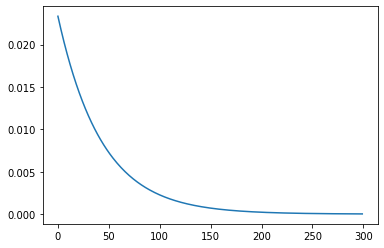

In [29]:
data = generate_exponential(300)
#data = generate_exponential_inv(300)
#data = generate_uniform(300)
lists = sorted(data.items())
x, y = zip(*lists)
cum_prob = get_cumulative_prob(y)
playlist = get_playlists(cum_prob)
plt.plot(x, y)
plt.show() 

In [30]:
random.seed(1234)
tf.random.set_seed(1)
playlist_list = []
data_exp = generate_exponential(300)
data_exp_inv = generate_exponential_inv(300)
data_uniform = generate_uniform(300)

data_exp = sorted(data_exp.items())
_, y_exp = zip(*data_exp)

data_exp_inv = sorted(data_exp_inv.items())
_, y_exp_inv = zip(*data_exp_inv)

data_uniform = sorted(data_uniform.items())
_, y_uni = zip(*data_uniform)

In [31]:
type = random.choices(population=[0,1,2], weights=[0.2307,0.6923,0.077], k=3000) #returns a list of choices

cum_prob_exp = get_cumulative_prob(y_exp) #GETS DIFFERENT PROBABIITIES
cum_prob_inv = get_cumulative_prob(y_exp_inv)
cum_prob_uni = get_cumulative_prob(y_uni)

targets = []

for i in type: #GET A RANDOM PLAYLIST OF A SPECIFIC TYPE
    if i == 1:
        pl = get_playlists(cum_prob_exp)
    elif i == 2:
        pl = get_playlists(cum_prob_inv)
    else:
        pl = get_playlists(cum_prob_uni)
    playlist_list.append(pl)
    targets.append(i)

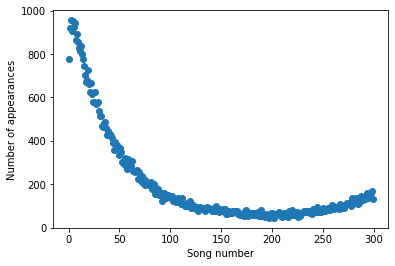

C:\Users\danie\AppData\Local\Temp\ipykernel_24628\4282934075.py:4: RuntimeWarning: invalid value encountered in true_divide
  pairs[num] /= total


In [34]:
popuarity = plot_playists_popularity(playlist_list) #returns the number of appearances of each song
playlists_ordered = order_playists(playlist_list)
pairs = create_pairs(playlist_list) #playlists_ordered
pairs2 = get_probabilities(pairs)
df2 = get_prob_dataframe(pairs2)
df = create_training_data(pairs)

# Regression test

In [59]:
def num_to_bin(n, length):
    num = n
    binary = []
    while num != 0:
        bit = num % 2
        binary.insert(0, bit)
        num = num // 2
    while len(binary) < length:
        binary.insert(0, 0)
    return np.array(binary)

In [148]:
#X = np.array([num_to_bin(n, 10) for n in df['Song']])
X = df['Song'].to_numpy()
#y = np.array(df['Next'])
y = df['Next'].to_numpy()
X

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [182]:
everything = list(zip(X, y))

random.shuffle(everything)

X_list, y_list = zip(*everything)

X_list = np.array(X)
y_list = np.array(y)



In [181]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

In [64]:
mean = df['Next'].mean()
std = df['Next'].std()

In [65]:
def make_model(input_fts):
    model = tf.keras.Sequential()
    model.add(Dense(2, input_dim=input_fts))
    return model

In [66]:
def gauss_loss(y_true, y_pred):
    """Negative log likelihood of y_true, with the likelihood defined by a normal distribution."""

    y_true = y_true[:, 0]
    means = y_pred[:, 0]
    # We predict the log of the standard deviation, so exponentiate the prediction here
    stds = tf.exp(y_pred[:, 1])
    variances = stds * stds

    log_p = (-tf.math.log(tf.sqrt(2 * math.pi * variances))
             -(y_true - means)*(y_true - means)/(2 * variances))

    return -log_p

In [204]:
def train_model(X, y, X_test, y_test):
    """Builds the model, trains it on the given data, and returns the trained model and history."""
    
    # Normalize y to have zero mean and unit variance
    y = y - mean
    y = y / std
    
    num_features = 1#len(X[0])
    model = make_model(num_features)
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2,
                                         clipvalue=1,
                                         decay=1e-3)

    callback = callbacks.EarlyStopping(monitor='val_loss', patience=2)
    model.compile(optimizer=optimizer,
                  loss='mean_squared_error',
                  metrics = [keras.metrics.MeanSquaredError(),
                            keras.metrics.RootMeanSquaredError(),
                            keras.metrics.MeanAbsoluteError(),
                            keras.metrics.MeanAbsolutePercentageError(),
                            keras.metrics.MeanSquaredLogarithmicError(),
                            keras.metrics.CosineSimilarity(),
                            keras.metrics.LogCoshError()])

    history = model.fit(X, y,
                        epochs=100,
                        validation_split = 0.2,
                        #validation_data=(X_test, y_test),
                        callbacks=[callback],
                        verbose=False)
    
    return model, history

In [68]:
def predict(model, X):
    
    predictions = model.predict(X)
    
    # Scale up means
    means = predictions[:, 0] * std + mean
    # Exponentiate and scale up log standard deviation
    stds = np.exp(predictions[:, 1]) * std
    
    return means, stds

In [205]:
#reg_model, hist = train_model(X_train, y_train, X_test, y_test)
reg_model, hist = train_model(X_list, y_list, X_test, y_test)

In [224]:
#reg_model.save('reg_model.h5')

In [ ]:
reg_model = keras.models.load_model('reg_model.h5')

In [368]:
hist.history.keys()

dict_keys(['loss', 'mean_squared_error', 'root_mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error', 'mean_squared_logarithmic_error', 'cosine_similarity', 'logcosh', 'val_loss', 'val_mean_squared_error', 'val_root_mean_squared_error', 'val_mean_absolute_error', 'val_mean_absolute_percentage_error', 'val_mean_squared_logarithmic_error', 'val_cosine_similarity', 'val_logcosh'])

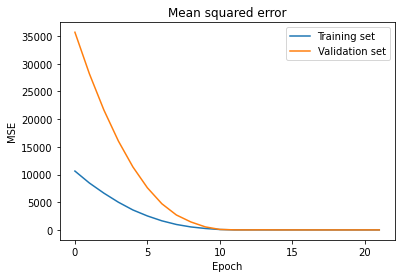

In [206]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title("Mean squared error")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.legend(["Training set", "Validation set"])

In [222]:
print(hist.history['loss'][21])
print(hist.history['root_mean_squared_error'][21])
print(hist.history['mean_absolute_error'][21])
print(hist.history['mean_absolute_percentage_error'][21])
print(hist.history['mean_squared_logarithmic_error'][21])
print(hist.history['cosine_similarity'][21])
print(hist.history['logcosh'][21])

0.8954516649246216
0.9462831020355225
0.7279109358787537
132.82566833496094
0.07655096799135208
0.21388961374759674
0.3362046182155609


In [223]:
print(hist.history['val_loss'][21])
print(hist.history['val_root_mean_squared_error'][21])
print(hist.history['val_mean_absolute_error'][21])
print(hist.history['val_mean_absolute_percentage_error'][21])
print(hist.history['val_mean_squared_logarithmic_error'][21])
print(hist.history['val_cosine_similarity'][21])
print(hist.history['val_logcosh'][21])

0.8971788883209229
0.947195291519165
0.915706992149353
66.39631652832031
0.26142844557762146
1.3109898567199707
0.3859446942806244


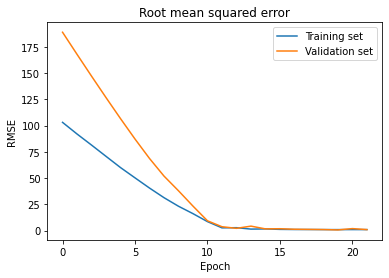

In [207]:
plt.plot(hist.history['root_mean_squared_error'])
plt.plot(hist.history['val_root_mean_squared_error'])
plt.title("Root mean squared error")
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.legend(["Training set", "Validation set"])

In [209]:
len(hist.history['loss'])

22

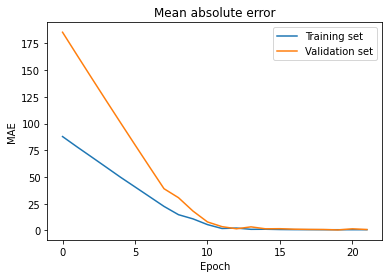

In [208]:
plt.plot(hist.history['mean_absolute_error'])
plt.plot(hist.history['val_mean_absolute_error'])
plt.title("Mean absolute error")
plt.xlabel("Epoch")
plt.ylabel("MAE")
plt.legend(["Training set", "Validation set"])

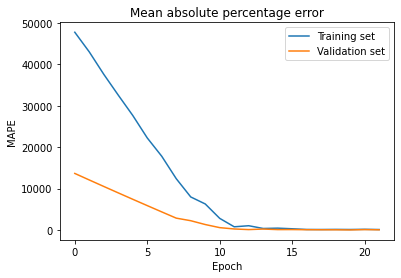

In [210]:
plt.plot(hist.history['mean_absolute_percentage_error'])
plt.plot(hist.history['val_mean_absolute_percentage_error'])
plt.title("Mean absolute percentage error")
plt.xlabel("Epoch")
plt.ylabel("MAPE")
plt.legend(["Training set", "Validation set"])

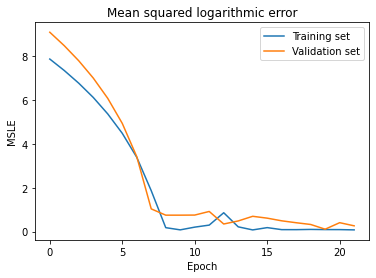

In [211]:
plt.plot(hist.history['mean_squared_logarithmic_error'])
plt.plot(hist.history['val_mean_squared_logarithmic_error'])
plt.title("Mean squared logarithmic error")
plt.xlabel("Epoch")
plt.ylabel("MSLE")
plt.legend(["Training set", "Validation set"])

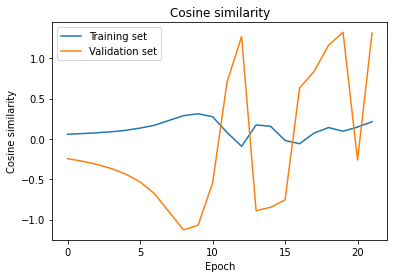

In [212]:
plt.plot(hist.history['cosine_similarity'])
plt.plot(hist.history['val_cosine_similarity'])
plt.title("Cosine similarity")
plt.xlabel("Epoch")
plt.ylabel("Cosine similarity")
plt.legend(["Training set", "Validation set"])

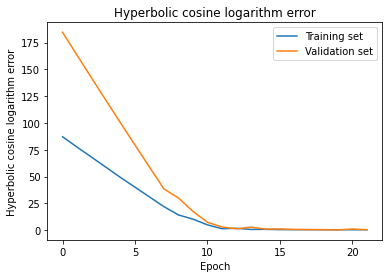

In [213]:
plt.plot(hist.history['logcosh'])
plt.plot(hist.history['val_logcosh'])
plt.title("Hyperbolic cosine logarithm error")
plt.xlabel("Epoch")
plt.ylabel("Hyperbolic cosine logarithm error")
plt.legend(["Training set", "Validation set"])

In [115]:
def visualize_prediction(prediction, actual, filename=None, bgcolor="#ffffff"):
    
    figure = plt.figure()
    
    means, stds = prediction
    prediction_data = pd.DataFrame({"predicted": means,
                                    "actual": actual,
                                    "min": means - stds,
                                    "max": means + stds})
    
    plot = prediction_data[["predicted", "actual"]].plot()
    
    plot.set_facecolor(bgcolor)

    plot.fill_between(prediction_data.index,
                      prediction_data["min"],
                      prediction_data["max"],
                      alpha=0.2, color='k')
    
    #if filename is not None:
    #    plt.savefig(filename, bbox_inches="tight", dpi=200)
    
    return figure, plot

(<Figure size 432x288 with 0 Axes>, <AxesSubplot:>)

<Figure size 432x288 with 0 Axes>

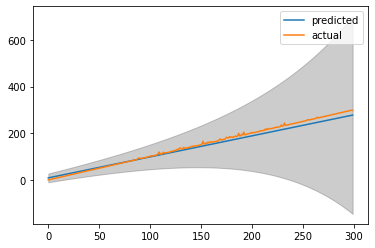

In [192]:
visualize_prediction(predict(reg_model, X), y, "song_prediction.svg")

In [244]:
reg_y_test = np.array([num_to_bin(n, 10) for n in list(range(300))])
means, stds = predict(reg_model, reg_y_test)
print(means[6])

15.520142
476.67322


In [201]:
reg_y_test = np.array(list(range(300)))
means, stds = predict(reg_model, reg_y_test)
print(means[299])

278.18005


In [348]:
print(means[290])
print(stds[290])

288.55945
437.58606


In [178]:
pred_means, pred_stds = predict(reg_model, X_test)

In [79]:
def get_mse(y_true, y_pred):
    mse = 0
    size = len(y_true)
    for i in range(size):
        mse += math.pow(y_true[i] - y_pred[i], 2)
    mse = mse / size
    return mse

In [179]:
mse = get_mse(y_test, pred_means)
print(mse)

364.4815305864613


In [117]:
def normpdf(x, mean, sd): #true_y, pred_y (mean), std
    var = float(sd)**2
    denom = (2*math.pi*var)**.5
    num = math.exp(-(float(x)-float(mean))**2/(2*var))
    return num/denom

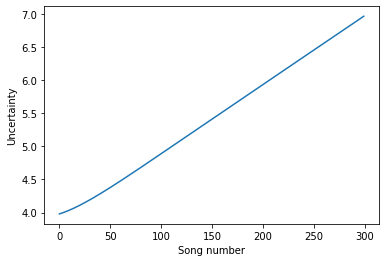

In [202]:
unc = []
for i in range(300):
    p = normpdf(df['Song'][i], means[i], stds[i]) 
    nll = -np.log(p)
    unc.append(nll)
plt.plot(unc)
plt.xlabel('Song number')
plt.ylabel('Uncertainty')
plt.show()

In [179]:
popuarity[3]
unc[3]

2.259119178503426

(-0.5685207183325689, 4.115866297591095e-16)
SpearmanrResult(correlation=-0.6972805720444409, pvalue=2.277848028086052e-26)
KendalltauResult(correlation=-0.5086359309125528, pvalue=3.9521381311188385e-23)


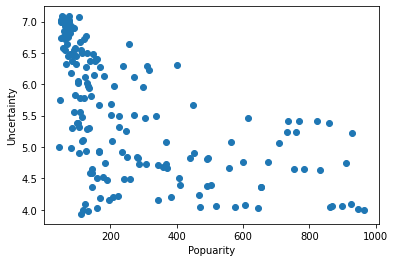

In [252]:
plot_uncertainty_pop(popuarity, unc)

(-0.6113920947271018, 2.0169704725089838e-19)
SpearmanrResult(correlation=-0.6580673563724412, pvalue=3.294697939803805e-23)
KendalltauResult(correlation=-0.4949350649350649, pvalue=1.8078772861757667e-22)


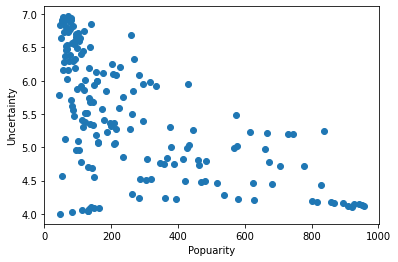

In [203]:
plot_uncertainty_pop(popuarity, unc)